In [41]:
import tweepy
import json
import pandas as pd
import copy
import nltk
import numpy as np
import re
import matplotlib.pyplot as pie_plot
from bokeh.io import show, output_file
from bokeh.plotting import figure
from math import pi
from operator import itemgetter
from collections import OrderedDict
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from nltk import pos_tag
from nltk import ngrams
import tkinter
from tkinter import *
from tkinter import messagebox  
from tkinter import filedialog

In [42]:
# function to authenticate the credentials to connect to twitter using Tweepy API
def authentication():
    auth = tweepy.OAuthHandler('2E7ZXMmYNVZg72y9ezHxB9vSd','gQp7w2ASkNalLOzr3wFRhnp6vxLeZFjBIhOlnvrlUJVL5R6vlh')
    auth.set_access_token('156562404-F5UtJpdluBBhlUpt4MX24ne9ZEq0leKCvMXTeXCK','0xJEifiJufhIfDGoPnkJWO1JYtVV8dBvkuZ6Lx0e6xx51')
    api=tweepy.API(auth,wait_on_rate_limit=True)
    return api

In [43]:
api = authentication()

In [44]:
# 1. Imports data from the 'Categories_List.csv' contains the categorical data into a dataframe
# 2. Imports data from the 'Users_Set_1.csv' contains the list of user names into a dataframe
def load_files(users_filename):
    try:
        global category_df
        cat_df = pd.read_csv('Categories_List.csv',encoding='ISO-8859-1')
        #print(category_df)
        category_df = pd.DataFrame()
        for column in cat_df.columns:
            col_count = 0
            column_data = cat_df[column].str.lower()
            category_df.insert(loc=col_count,column=column,value=pd.Series(column_data))
            col_count+=1
        #initalise user data set frame
        global users_df
        users_df = pd.read_csv(users_filename,encoding='ISO-8859-1')
    except:
        print("Please load the categories and user data set...")
    

In [45]:
# function to write data into a CSV file
def writeToCsv(name,df):
    df.to_csv(''+name+'.csv',encoding='utf-8',index=False)

In [46]:
# function to remove non-ASCII characters from a text
def removeNonAscii(text):
    return "".join(char for char in text if ord(char) < 128)

In [47]:
# function to fetch tweet results using cursors
def limit_handled(cursor):
    while True:
        try:
            yield cursor.next()
        except StopIteration:
            return
        """except tweepy.RateLimitError:
            print("Time Limit. Sleeping now....")
            time.sleep(15 * 60)
            print("Trying again")"""

In [48]:
# 1. function to extract tweets,retweets & favorites of a given user
# 2. Data cleansing like - removing unneccessary words from the tweets are performed
# 3. Results are stored in the dataframe.
# 4. A CSV file of the fotmat - 'ScreeName.csv' will be exported containing a list of tweets, retweets and favorites.
def extractTweets(screen_name):
    #create empty data frame
    dataFrame = pd.DataFrame()
    tweet_count=0
    retweet_count=0
    fav_count=0
    tweet_text=[] # list of tweets
    retweet_text=[] # list of retweets
    fav_text=[] # list of favorite tweets
    for tweets in limit_handled(tweepy.Cursor(api.user_timeline,screen_name=screen_name,count=200,tweet_mode='extended').items()):
        #print("Created at:%s, tweet is : %s " %(tweets.created_at,tweets.text))
        if (tweets.lang == "en"):
            raw_text = tweets.full_text
            text = re.sub(r"http\S+","",raw_text)
            tweet_text.append(removeNonAscii(text))
            tweet_count+=1
        if hasattr(tweets,'retweeted_status'):
            if (tweets.retweeted_status.lang == "en"):
                raw_text = tweets.retweeted_status.full_text
                text = re.sub(r"http\S+","",raw_text)
                retweet_text.append(removeNonAscii(text))            
                retweet_count+=1        
        if(tweet_count == 2980 or retweet_count == 2980):
            break
    for fav_tweets in limit_handled(tweepy.Cursor(api.favorites,id=screen_name,tweet_mode='extended').items()):
        if(fav_tweets.lang  == 'en'):
            raw_text = fav_tweets.full_text
            text = re.sub(r"http\S+","",raw_text)
            fav_text.append(removeNonAscii(text))
            fav_count+=1
        if (fav_count > 200):
            break
    #print(tweet_count)
    # insert tweets in the dataframe
    dataFrame.insert(loc=0,column='Tweets',value=pd.Series(tweet_text)) 
    # insert retweets in the dataframe
    dataFrame.insert(loc=1,column='Retweets',value=pd.Series(retweet_text))
    #insert favorite tweets in the dataframe
    dataFrame.insert(loc=2,column='Favorite Tweets',value= pd.Series(fav_text))
    #print(dataFrame)
    writeToCsv(screen_name,dataFrame)
    performSentimentAnalysis(screen_name,dataFrame)

In [49]:
# 1.function to perform sentioment analysis of all the tweets
def performSentimentAnalysis(screen_name,dataFrame):
    df = copy.deepcopy(dataFrame)
    senti_df = df['Tweets'].append([df['Retweets'],df['Favorite Tweets']]).reset_index(drop=True)
    senti_df = pd.DataFrame(senti_df,columns=['twitter_text']).dropna()
    senti_df['category'] = np.nan
    senti_df = senti_df.reset_index(drop=True) 
    analyseSentiment = SentimentIntensityAnalyzer()
    for itr in range(0,len(senti_df)):
        index = list(np.where(senti_df['twitter_text'] == senti_df.iloc[itr]['twitter_text'] )[0])
        senti_score = analyseSentiment.polarity_scores(senti_df.iloc[itr]['twitter_text'])
        #classify pos or neg category based on the compound score
        if (senti_score['compound'] > 0.0):
            senti_df.loc[index,'category'] = 'positive'
        else:
            senti_df.loc[index,'category'] = 'negative'        
    writeToCsv(screen_name + '_Sentiment',senti_df)
    #print(senti_df)
    analyseText(senti_df,screen_name)   

In [50]:
# 1.function that takes the positive tweets, performs data cleansing and noun related words are extracted.
def analyseText(senti_df,screen_name):
    dataFrame = copy.deepcopy(senti_df)
    index = list(np.where(dataFrame['category'] == 'positive')[0])
    positive_text=[]
    all_text=[]
    all_nouns_text=[]
    for index_count in range(0,len(index)):
        positive_text.append(dataFrame.iloc[index_count]['twitter_text'])
    # set the stop words
    stop_words = set(stopwords.words('English'))
    #set the stemmer
    #stemmer = PorterStemmer()
    for itr in range(0,len(positive_text)):
        #tokenize
        tokens = word_tokenize(positive_text[itr])
        #remove stop words & punctuation(other characters)
        filtered_text = [ word.lower() for word in tokens if (word not in stop_words) and (word.isalpha()) and (len(word) > 1)]
        #print(filtered_text)
        # get list of all tokens
        all_text+=filtered_text
    #print(all_text)
    # resort to all stemmed words
    #all_stemmed_text = [stemmer.stem(word) for word in all_text]
    #print(all_stemmed_text)
    # take only the nouns
    tags = pos_tag(all_text)
    for word,pos in tags:
            if pos in ['NN','NNS','NNP','NNPS']:
                all_nouns_text.append(word)
    #print(all_nouns_text)
    getTopWords(all_nouns_text,screen_name)

In [51]:
# 1. function that gets the highest frequency words from the unigram, bigrams and trigrams list.
def getTopWords(all_nouns_text,screen_name):
    nouns_text = copy.deepcopy(all_nouns_text)
    topCount_df=pd.DataFrame()
    all_single=[]
    all_bigrams=[]
    all_trigrams=[]
    # for single words
    freq_single = Counter(nouns_text)
    for token,count in freq_single.most_common(10):
        all_single.append(token)
    # for bigrams
    bigrams = list(ngrams(nouns_text,2))
    freq_bi = Counter(bigrams)
    for token,count in freq_bi.most_common(10):
        all_bigrams.append(list(token))
    #for trigrams
    trigrams = list(ngrams(nouns_text,3))
    freq_tri = Counter(trigrams)
    for token,count in freq_tri.most_common(10):
        all_trigrams.append(list(token))
    # add single word top counts to the dataframe
    topCount_df.insert(loc=0,column='Single',value=pd.Series(all_single))
    # add bigrams word top count to the dataframe
    topCount_df.insert(loc=1,column='Bigrams',value=pd.Series(all_bigrams))
    # add trigrams word top count to the dataframe
    topCount_df.insert(loc=2,column='Trigrams',value=pd.Series(all_trigrams))
    #print(topCount_df)
    #writeToCsv('top_count',topCount_df)
    findCategories(topCount_df,screen_name)   

In [52]:
# 1. function that keeps track of the number of words belongs to what categories.
def findCategories(topCount_df,screen_name):
    count_df = copy.deepcopy(topCount_df)
    # create dictionaries for tracking word cout & categories
    word_count_dict = {}
    word_category_dict = {}
    for row_itr in range(0,len(count_df)):
        for column_itr in range(0,len(count_df.columns)):
            key = count_df.iloc[row_itr][column_itr]
            if isinstance(key,str):
            #check if this key is already present in the dictionary
                if key not in word_count_dict.keys():
                    word_count_dict[key] = 0
                    word_category_dict[key] = []
            elif isinstance(key,list):
                for key_list in key:
                    if key_list not in word_count_dict.keys():
                        word_count_dict[key_list] = 0  
                        word_category_dict[key_list] = [] 
    #print(word_count_dict)
    # update count values in word_count_dict & categories in word_category_dict
    column_labels = list(category_df.columns)
    for key in word_count_dict.keys():
        for column in column_labels: 
            if any(category_df[column] == key):
                word_count_dict[key] +=1 
                word_category_dict[key].append(column)
    #print(word_count_dict)
    #print(word_category_dict)
    #sorted_word_count_dict = OrderedDict(sorted(word_count_dict.items(),key = itemgetter(1),reverse = True)[:5])
    #print(sorted_word_count_dict)
    #categoryWisePercent(sorted_word_count_dict,word_category_dict)
    categoryWisePercent(word_count_dict,word_category_dict,screen_name)
    

In [53]:
# 1. function that classifies words belonging to each categories and caluclates the categorywise percentage
def categoryWisePercent(word_count_dict,word_category_dict,screen_name):
    sorted_word_dict = copy.deepcopy(word_count_dict)
    category_dict = copy.deepcopy(word_category_dict)
    # create empty dataframe
    percent_df = pd.DataFrame(columns = ['Category','Words','Percentage'])
    # categorize it
    category_list= []
    for key in sorted_word_dict:
        cat_list = list (category_dict[key])
        for itr in range(0,len(cat_list)):
            if cat_list[itr] not in category_list:
                category_list.append(cat_list[itr])
    percent_df['Category'] = category_list
    percent_df['Words'] = 0
    percent_df['Percentage'] = 0 
    #fill words column
    for key in sorted_word_dict:
        cat_list = list(category_dict[key])
        for itr in range(0,len(cat_list)):
            index = list(np.where(percent_df['Category'] == cat_list[itr])[0])
            percent_df.at[index,'Words'] = percent_df['Words'][index] +1
    # fill percentage column
    total_word_count=0
    for row_count in range(0,len(percent_df)):
        total_word_count += percent_df['Words'][row_count]
    for row_count in range(0,len(percent_df)):
        percent_df.at[row_count,'Percentage'] = ( percent_df['Words'][row_count] / total_word_count) * 100
    percent_df.sort_values(['Percentage'],ascending = False, inplace = True)
    percent_df = percent_df.reset_index(drop = True)
    print(percent_df.to_string())
    listUsers_df.append(percent_df)     
    plot_piechart(percent_df,screen_name)    

In [54]:
# 1. function that plots the pie chart based on the classified categories 
def plot_piechart(percent_df,screen_name):
    per_df = copy.deepcopy(percent_df)
    max_value= max(list(per_df['Words']))
    index = list(np.where(per_df['Words'] == max_value)[0])
    explode_list = []
    for itr in range(0,len(per_df)):
        if itr in index:
            explode_list.append(0.1)
        else:
            explode_list.append(0.0)        
    #print(explode_list)
    explode_tuple = tuple(explode_list) 
    labels = list(per_df['Category'])
    values = list(per_df['Words'])
    figureObject,axesObject = pie_plot.subplots(figsize=[8, 8])
    axesObject.set_title(''+screen_name+'- Interests')
    axesObject.pie(values,labels =labels,autopct = '%.1f%%',startangle = 90, explode = explode_tuple)
    axesObject.axis('equal')
    pie_plot.show()
    

In [55]:
# 1. function that classifies users belonging to each category.
# 2. 'User_Categorized_List.csv' contains the list of users against different categories.
def visualize_bar_chart():
    categorized_user_df = pd.DataFrame(columns = ['Categories','Number Of Users','Percentage','User Names'])
    unique_category_list = []
    highest_user_categories_list = []
    for each_user_df in listUsers_df:
        temp_cat_list = []
        if each_user_df['Category'][0] not in unique_category_list:
            unique_category_list.append(each_user_df['Category'][0])
        if each_user_df['Category'][0] not in temp_cat_list:
            temp_cat_list.append(each_user_df['Category'][0])
        max_percentage = each_user_df['Percentage'][0]
        for row in range(1,len(each_user_df)):
            if (max_percentage - each_user_df['Percentage'][row] <= 10):
                if (each_user_df['Category'][row] not in unique_category_list):
                    unique_category_list.append(each_user_df['Category'][row])
                if each_user_df['Category'][row] not in temp_cat_list:
                    temp_cat_list.append(each_user_df['Category'][row])
        highest_user_categories_list.append(temp_cat_list)
    #print(highest_user_categories_list)
    categorized_user_df['Categories'] = unique_category_list
    categorized_user_df['Number Of Users'] = 0
    categorized_user_df['Percentage'] = 0
    categorized_user_df['User Names'] = ''
    # fill the number of users column
    user_name_count = 0
    for cat_list in highest_user_categories_list:
        for category in cat_list:
            if category in unique_category_list:
                #print(category)
                index = list(np.where(categorized_user_df['Categories'] == category)[0])
                categorized_user_df.at[index[0],'Number Of Users'] = categorized_user_df['Number Of Users'][index[0]] + 1
                categorized_user_df.at[index[0],'User Names'] = categorized_user_df['User Names'][index[0]] + users_df['Users'][user_name_count] + ','
        user_name_count += 1
    #remove last character from the string
    categorized_user_df['User Names'] = categorized_user_df['User Names'].str.rstrip(',')
    # fill percentage column
    total_users_count = sum(categorized_user_df['Number Of Users'])
    for user_count in range(0,len(categorized_user_df)):
        categorized_user_df.at[user_count,'Percentage'] = (categorized_user_df['Number Of Users'][user_count] / total_users_count ) * 100 
    print(categorized_user_df.to_string())
    writeToCsv('User_Categorized_List',categorized_user_df)
    #visualise the categorised users in a bar chart
    draw_bar_chart(categorized_user_df)              

In [56]:
# 1. functoin to draw the pie chart
def draw_bar_chart(categorized_user_df):
    output_file("Categories_Vs_Percentage.html")
    categories = list(categorized_user_df['Categories'])
    p = figure(x_range=categories, 
               plot_height=550, 
               plot_width = 550, 
               title="Categories Vs Number Of Users",
               x_axis_label ='Categories',
               y_axis_label='Percentage',
               toolbar_location=None, tools="")
    p.vbar(x=categories, top=list(categorized_user_df['Percentage']), width=.6)
    p.xgrid.grid_line_color = None
    p.y_range.start = 1
    p.title.text_color='Green'
    p.title.text_font='times'
    p.title.text_font_style='italic'
    p.title.text_font_size='15pt'
    p.title.align='center'
    p.xaxis.major_label_orientation = pi/3  # for rotating the x axis labels
    p.xaxis.axis_label_text_font_size = "15pt"
    p.xaxis.axis_label_text_color='Red'
    p.yaxis.axis_label_text_font_size = "15pt"
    p.yaxis.axis_label_text_color='Orange'
    show(p)

In [57]:
def main():
    #option = input("Enter the screen name / names. Choose from the below option:"+'\n'+"1. Single User"+'\n'+"2. Set Of Users"+'\n')
    global listUsers_df
    listUsers_df = []
    for user_name in users_df['Users']:
        print('User Name : %s' %user_name)
        extractTweets(user_name)
    visualize_bar_chart() 

In [58]:
#main()

In [59]:
# 1 . function to browse for the user dataset file.
def browseFile():
    global filename
    if textbox.compare("end-1c","!=","1.0"):
        textbox.delete(1.0,END)
    if lb1.index('end') != 0:
        lb1.delete(0,END)        
    filename = filedialog.askopenfilename(initialdir="/",title="Select File",filetypes = 
                                                                                        (("CSV Files","*.csv"),("All Files","*.*"))
                                         )
    textbox.insert(END,filename)

# 1. function to execute the whole process when 'Execute' button from UI is clicked
def execute():
    if lb1.index('end') != 0:
        lb1.delete(0,END) 
    if filename != "":
        lb1.insert(1,"Execution Started")
        load_files(filename)
        lb1.insert(2,"Interest Identification & Pie Chart Generation In Progress")
        main()
        lb1.insert(3,"Execution Completed")
        msg = messagebox.showinfo('Success','Results Generated Successfully')  
    else:
        msg = messagebox.showinfo('Error','Please browse and select the user dataset file')
    

User Name : sachin_rt
                 Category  Words  Percentage
0                  Sports      4          28
1                Shopping      3          21
2                 History      3          21
3                Politics      2          14
4  Information Technology      1           7
5         Medical Science      1           7


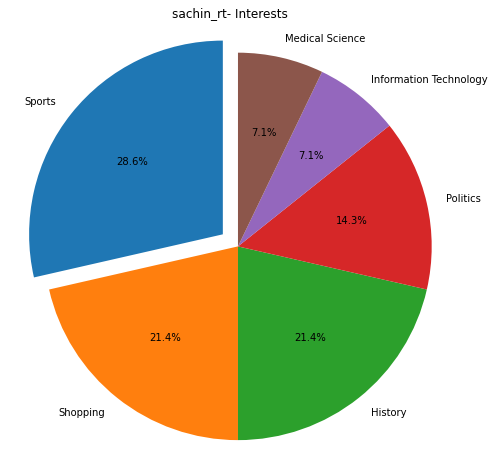

User Name : virendersehwag
                   Category  Words  Percentage
0                  Shopping      3          25
1                    Sports      3          25
2                   History      2          16
3    Information Technology      1           8
4                  Politics      1           8
5  Story Reading And Novels      1           8
6           Medical Science      1           8


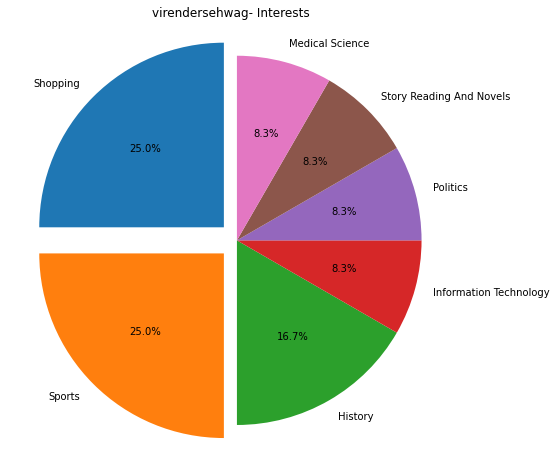

User Name : Cristiano
                    Category  Words  Percentage
0                     Sports      6          20
1                     Travel      4          13
2                   Shopping      4          13
3                    History      4          13
4   Story Reading And Novels      3          10
5              Entertainment      2           6
6            Medical Science      2           6
7                       Food      1           3
8                   Politics      1           3
9                    Finance      1           3
10    Information Technology      1           3
11                 Education      1           3


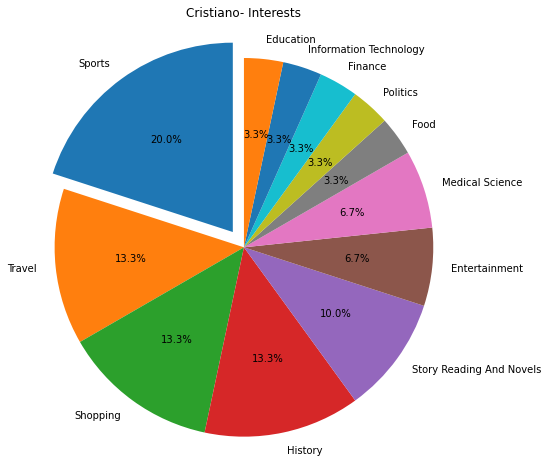

User Name : JustinTrudeau
                   Category  Words  Percentage
0                   History      6          17
1                   Finance      5          14
2                  Shopping      5          14
3                      Food      3           8
4                    Travel      3           8
5                  Politics      3           8
6  Story Reading And Novels      3           8
7                    Sports      3           8
8                 Education      2           5
9    Information Technology      2           5


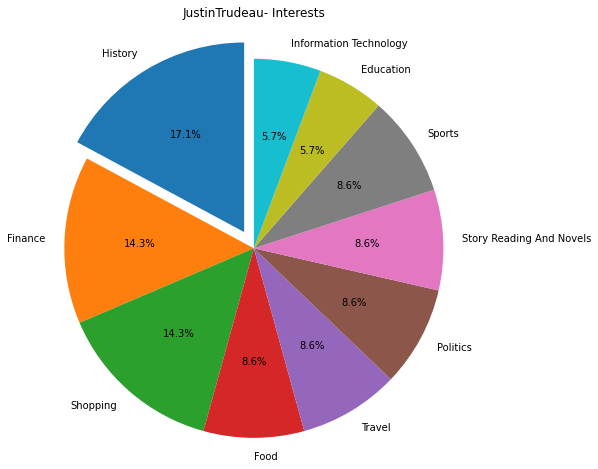

User Name : lbjamesharden
                   Category  Words  Percentage
0  Story Reading And Novels      6          25
1                      Food      3          12
2           Medical Science      3          12
3             Entertainment      2           8
4                    Sports      2           8
5                    Travel      2           8
6                   Finance      2           8
7                 Education      2           8
8                  Politics      1           4
9                   History      1           4


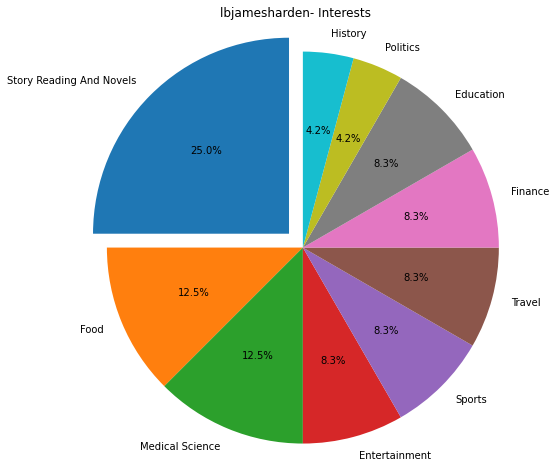

User Name : PawanKalyan
                   Category  Words  Percentage
0                  Shopping      2          22
1                   Finance      2          22
2  Story Reading And Novels      1          11
3           Medical Science      1          11
4                   History      1          11
5                 Education      1          11
6                  Politics      1          11


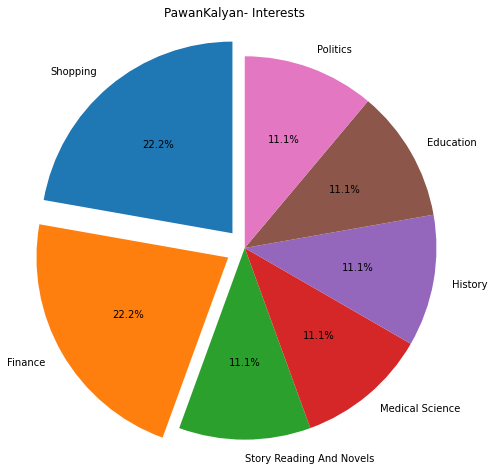

User Name : realDonaldTrump
                   Category  Words  Percentage
0  Story Reading And Novels      2          14
1                  Politics      2          14
2                    Sports      2          14
3                   History      2          14
4                    Travel      2          14
5             Entertainment      1           7
6                      Food      1           7
7                 Education      1           7
8           Medical Science      1           7


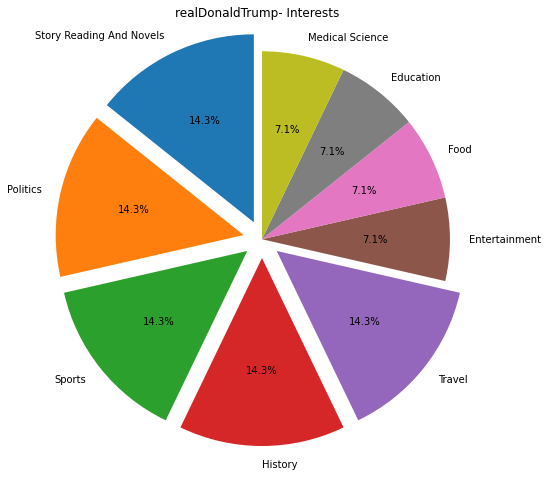

User Name : RaviShastriOfc
                   Category  Words  Percentage
0                    Sports      6          30
1                   History      3          15
2    Information Technology      2          10
3                    Travel      2          10
4                  Politics      2          10
5                  Shopping      2          10
6           Medical Science      1           5
7  Story Reading And Novels      1           5
8             Entertainment      1           5


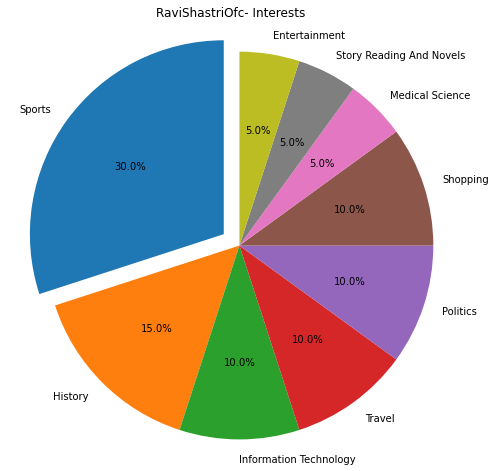

User Name : KP24
                    Category  Words  Percentage
0                   Shopping      7          15
1                    History      7          15
2                   Politics      6          13
3                     Sports      5          11
4                     Travel      4           8
5   Story Reading And Novels      4           8
6              Entertainment      3           6
7                    Finance      3           6
8                  Education      2           4
9            Medical Science      2           4
10    Information Technology      2           4


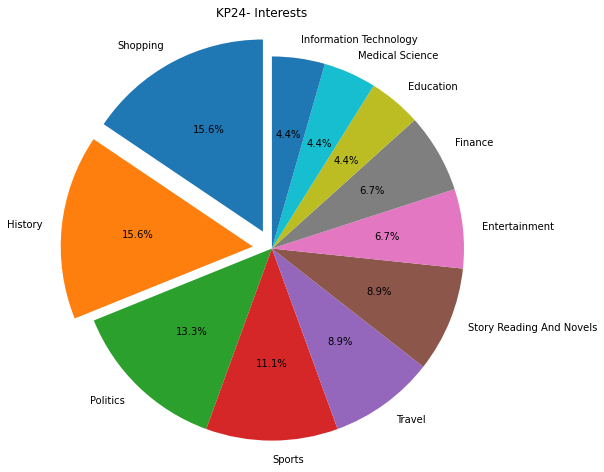

User Name : PTTVOnlineNews
                 Category  Words  Percentage
0                Politics      4          33
1           Entertainment      3          25
2               Education      2          16
3                 Finance      2          16
4  Information Technology      1           8


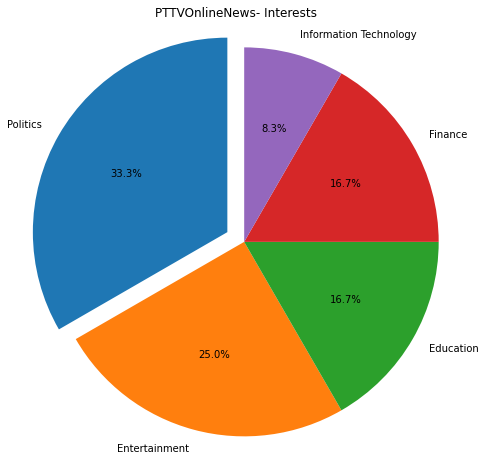

User Name : TheRock
                   Category  Words  Percentage
0  Story Reading And Novels      3          33
1                  Shopping      2          22
2                   History      2          22
3                    Travel      1          11
4                 Education      1          11


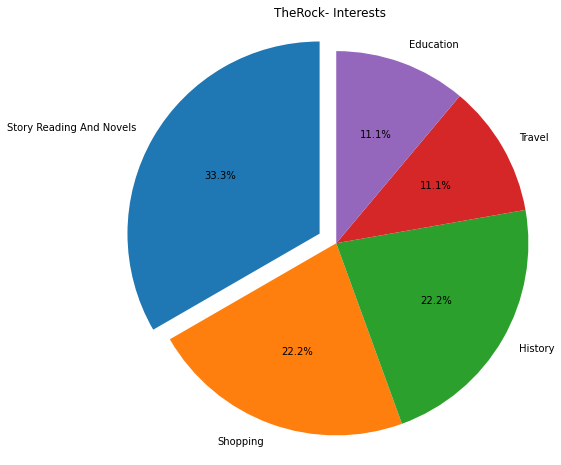

                  Categories  Number Of Users  Percentage                                                                            User Names
0                     Sports                7          16  sachin_rt,virendersehwag,Cristiano,JustinTrudeau,realDonaldTrump,RaviShastriOfc,KP24
1                   Shopping                6          13                     sachin_rt,virendersehwag,Cristiano,JustinTrudeau,PawanKalyan,KP24
2                    History                6          13                 sachin_rt,virendersehwag,Cristiano,JustinTrudeau,realDonaldTrump,KP24
3                     Travel                4           9                                          Cristiano,JustinTrudeau,realDonaldTrump,KP24
4   Story Reading And Novels                6          13                    Cristiano,JustinTrudeau,lbjamesharden,realDonaldTrump,KP24,TheRock
5                    Finance                3           6                                                        JustinTrudeau,PawanKaly

In [60]:
# UI elements
root= tkinter.Tk()
root.title('User Interest Classifier Tool')
root.geometry('500x450+600+400')
# add text box
textbox = Text(root,height=1.5,width=40)
textbox.place(x=150,y=150)
# add path label
path_label = Label(root,text="Path of the user file")
path_label.place(x=10,y=150)
#add status label
status_label = Label(root,text='Status')
status_label.place(x=40,y=200)
# add browse & execute buttons
browse = Button(root,text='Browse',command = browseFile)
execute = Button(root,text='Execute',command=execute)
browse.place(x=100,y=50)
execute.place(x=300,y=50)
# add listbox
lb1= Listbox(root)
lb1.place(x=150,y=200,width=300)
filename=""
root.mainloop()